# Homework 4

In [1]:
#importing needed packages
import xarray as xr 

import matplotlib
import matplotlib.pyplot as plt 

import numpy as np 

import pandas as pd

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import dask
from dask.distributed import performance_report, Client, progress

import warnings
warnings.filterwarnings('ignore')

from eofs.xarray import Eof
from eofs.examples import example_data_path

%config InlineBackend.figure_format='retina'
plt.rcParams["font.family"] = "Arial"

/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [2]:
#I used dask just to try and speed up reading in the data
client = Client()
client

<Client: 'tcp://127.0.0.1:50604' processes=4 threads=8, memory=16.00 GiB>

1. Create a dataset that contains the monthly means of Sea Surface Temperature anomalies and precipitation anomalies from Jan 1979-Dec 2021 over the Pacific Basin (65°N to 65°S, 120°E to 60°W) masked out over land - save this to your computer. The land sea mask is available here: https://rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc

In [3]:
#creating URLs needed to get every year between 1979 and 2021
y = np.arange(1979, 2022, 1).astype(str)

mon_mean_pre_files = []
mon_mean_sst_files = []

for i in range(len(y)): 
    mon_mean_pre_files.append('https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/' + y[i] + '/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.' + y[i] + '010100_' + y[i] + '120100.nc')
    mon_mean_sst_files.append('https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/' + y[i] + '/e5.moda.an.sfc.128_034_sstk.ll025sc.' + y[i] + '010100_' + y[i] + '120100.nc')
    
    
mon_mean_pre = xr.open_mfdataset(mon_mean_pre_files, chunks = {'time': '50MB'}).sel(latitude=slice(65, -65), longitude=slice(120, 360 - 60))
mon_mean_sst = xr.open_mfdataset(mon_mean_sst_files, chunks = {'time': '50MB'}).sel(latitude=slice(65, -65), longitude=slice(120, 360 - 60))

lsm = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc'
land_mask = xr.open_mfdataset([lsm], chunks = {'time': '50MB'}).sel(latitude=slice(65, -65), longitude=slice(120, 360 - 60))

In [4]:
#retrieving the data
mmp = mon_mean_pre.compute()
mms = mon_mean_sst.compute()
lm = land_mask.compute()

/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.wa

In [7]:
#adding land mask to precipitation and sst data 
mmp_lsm = mmp.where(lm['LSM'][0] == 0)
mms_lsm = mms.where(lm['LSM'][0] == 0)

In [8]:
#Calculating the anomaly for all time periods 
mmp_anom = mmp_lsm['TP'] - mmp_lsm['TP'].mean(axis = 0)
mms_anom = mms_lsm['SSTK'] - mms_lsm['SSTK'].mean(axis = 0)

In [9]:
#creating a new data frame of the anomaly data 
ds = xr.Dataset(data_vars=dict(
                sst_anom = (["time", "latitude", "longitude"], mms_anom.data, {'Units':'K', 'Long_Name':'sea surface temperature anomaly with long term mean substracted (1979-2021)'}),
                pre_anom = (["time", "latitude", "longitude"], mmp_anom.data, {'Units':'M', 'Long_Name':'precipitation anomaly with long term mean substracted (1979-2021)'}),),

                coords=dict(
                lon=(["longitude"], mmp_anom.longitude.data),
                lat=(["latitude"], mmp_anom.latitude.data),
                time=mmp_anom.time.data,),

                attrs=dict(description="SST and Precipitation Anomaly Data"),)

In [10]:
#saving it to my computer
ds.to_netcdf('/Users/troyzaremba/Desktop/sst_precip_anom.nc')

2. From the dataset shown in 1, deseasonalize (remove the mean monthly anomaly from the annual mean from each point), detrend, and standardize the SST anomalies. Standardization means subtract the long term mean and divide by the standard deviation, which can be accomplished using the methods described here: 6.3. Preprocessing data — scikit-learn 1.1.2 documentation

In [11]:
#reading in new data, deseasonalizing, detrending, and standardizing SST anomalies. Variables 
#correspond to preprocessing steps
ds_read_in = xr.open_dataset('/Users/troyzaremba/Desktop/sst_precip_anom.nc')

climatology_sst = ds_read_in['sst_anom'].groupby("time.month").mean("time")
anomalies_sst = ds_read_in['sst_anom'].groupby("time.month") - climatology_sst

climatology_mmp = ds_read_in['pre_anom'].groupby("time.month").mean("time")
anomalies_mmp = ds_read_in['pre_anom'].groupby("time.month") - climatology_mmp

def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    
    return da - fit

detrend_sst = detrend_dim(anomalies_sst, 'time')
detrend_mmp = detrend_dim(anomalies_mmp, 'time')

sst_stand = (detrend_sst - detrend_sst.mean(axis = 0))/ detrend_sst.std(axis = 0)
pre_stand = (detrend_mmp - detrend_mmp.mean(axis = 0))/ detrend_mmp.std(axis = 0)

3. Perform an EOF analysis (with cosine latitude weighting) on the SST anomalies and plot a map of the first 5 EOFs.

In [12]:
#removing unnecessary axes
sst_stand['latitude'] = detrend_sst.lat
sst_stand['longitude'] = detrend_sst.lon

pre_stand['latitude'] = detrend_mmp.lat
pre_stand['longitude'] = detrend_sst.lon

sst_stand = sst_stand.drop(['lon', 'lat', 'month'])
pre_stand = pre_stand.drop(['lon', 'lat', 'month'])

In [13]:
#running EOF analysis 
coslat = np.cos(np.deg2rad(sst_stand.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
sst_solver = Eof(sst_stand, weights=wgts)
sst_eofs = sst_solver.eofs(neofs=5)

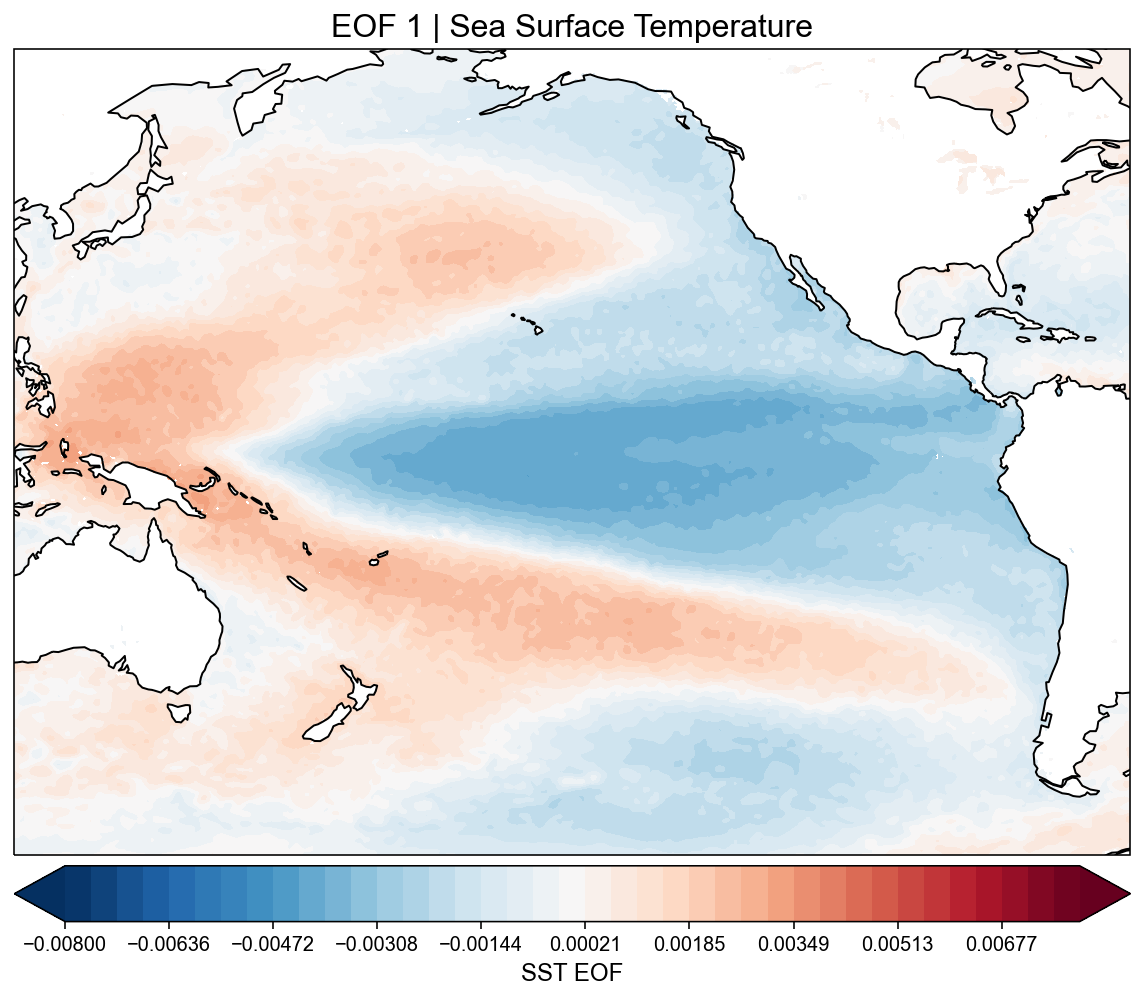

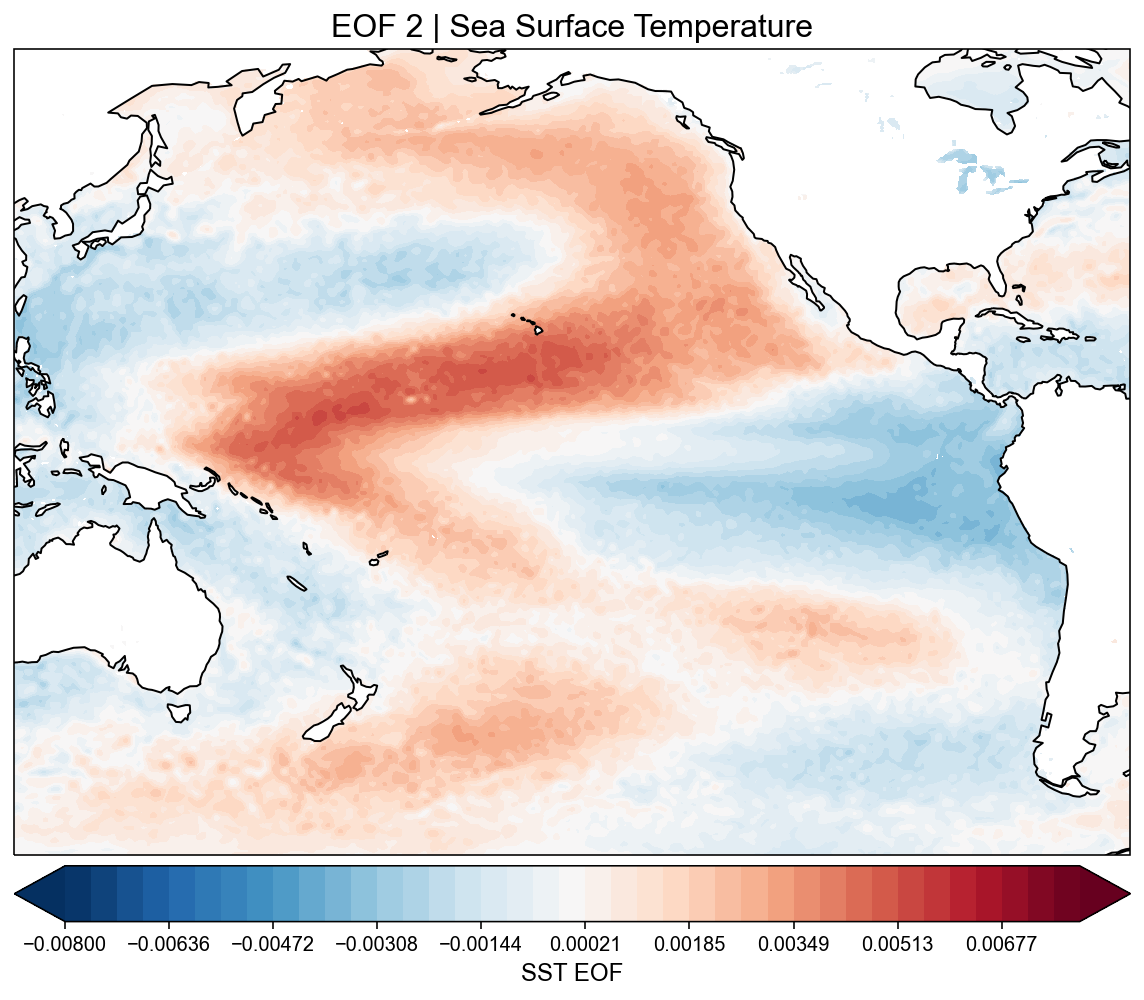

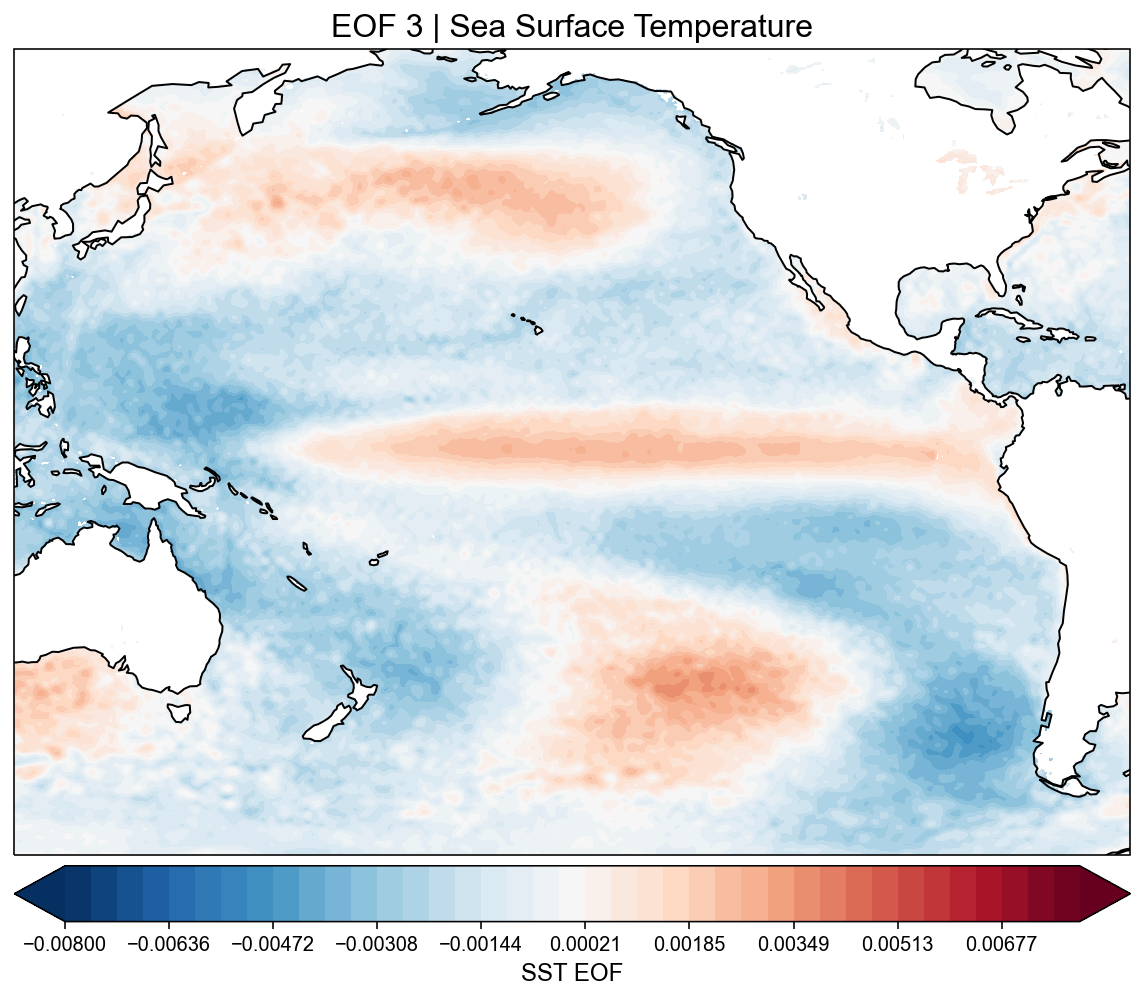

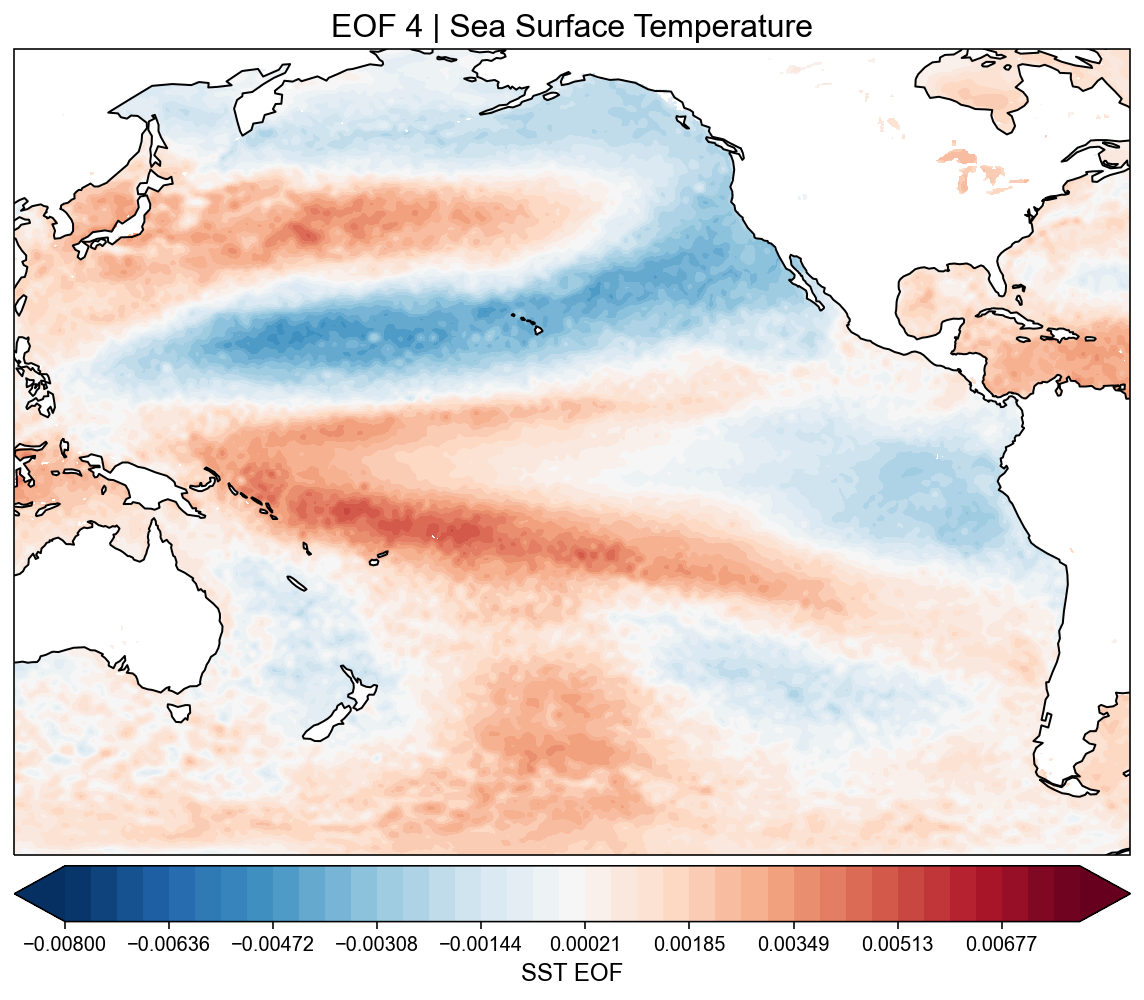

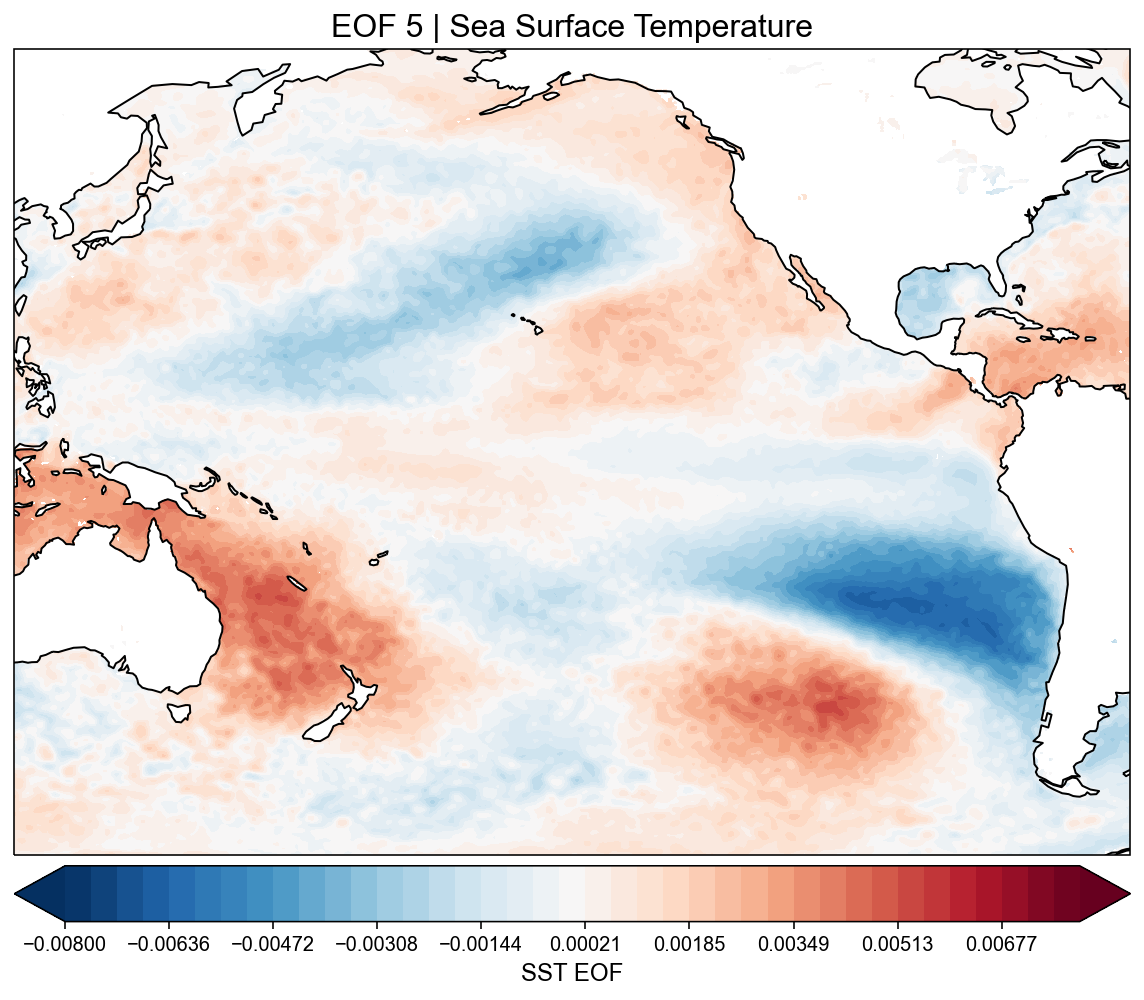

In [14]:
#plotting first five EOFs showing the greatest amount of variation for first five EOFs
for i in range(len(sst_eofs)): 

    clevs = np.linspace(-0.008, 0.008, 40)

    fig = plt.figure(figsize = (10, 10))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))

    fill = ax.contourf(sst_eofs.longitude.values, sst_eofs.latitude.values, sst_eofs[i].data, levels = clevs, cmap=plt.cm.RdBu_r,
                                     add_colorbar=False, transform=ccrs.PlateCarree(), extend = 'both')

    ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
    cb = plt.colorbar(fill, orientation='horizontal', pad = 0.01)

    cb.set_label('SST EOF', fontsize=12)
    ax.set_title('EOF ' + str(i + 1) + ' | Sea Surface Temperature', fontsize=16)

    plt.show()

In [15]:
#Precipitation EOFs
pre_solver = Eof(pre_stand, weights=wgts)
pre_eofs = pre_solver.eofs(neofs=5)

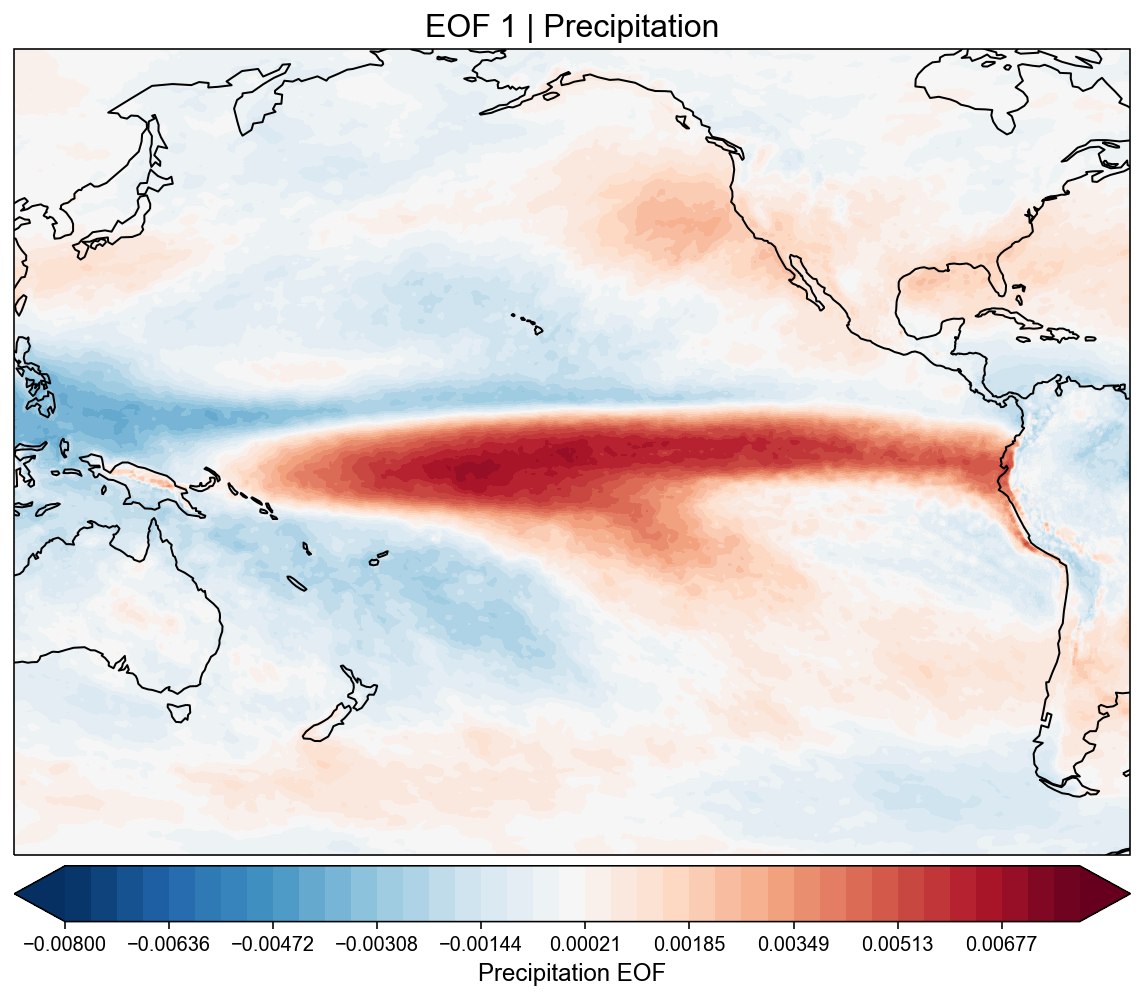

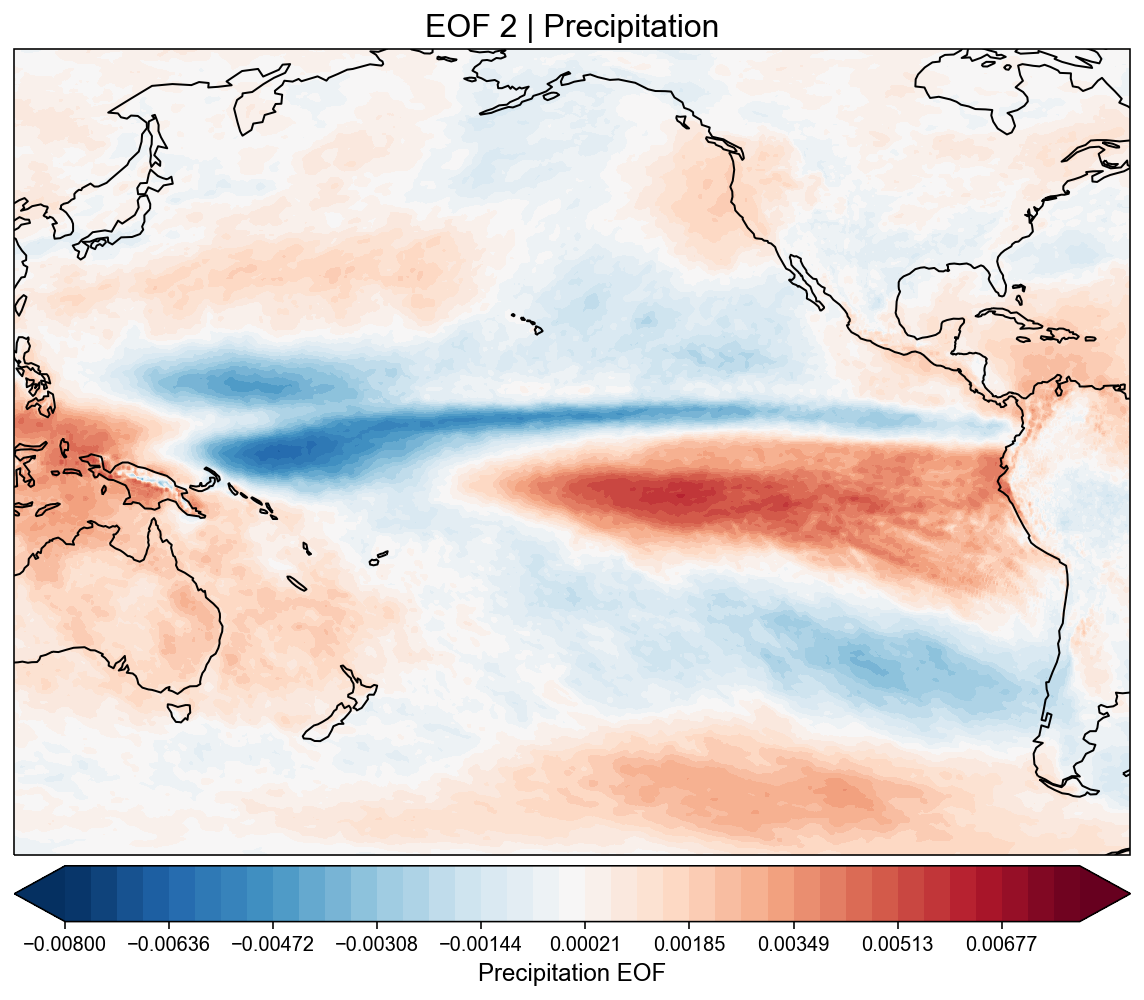

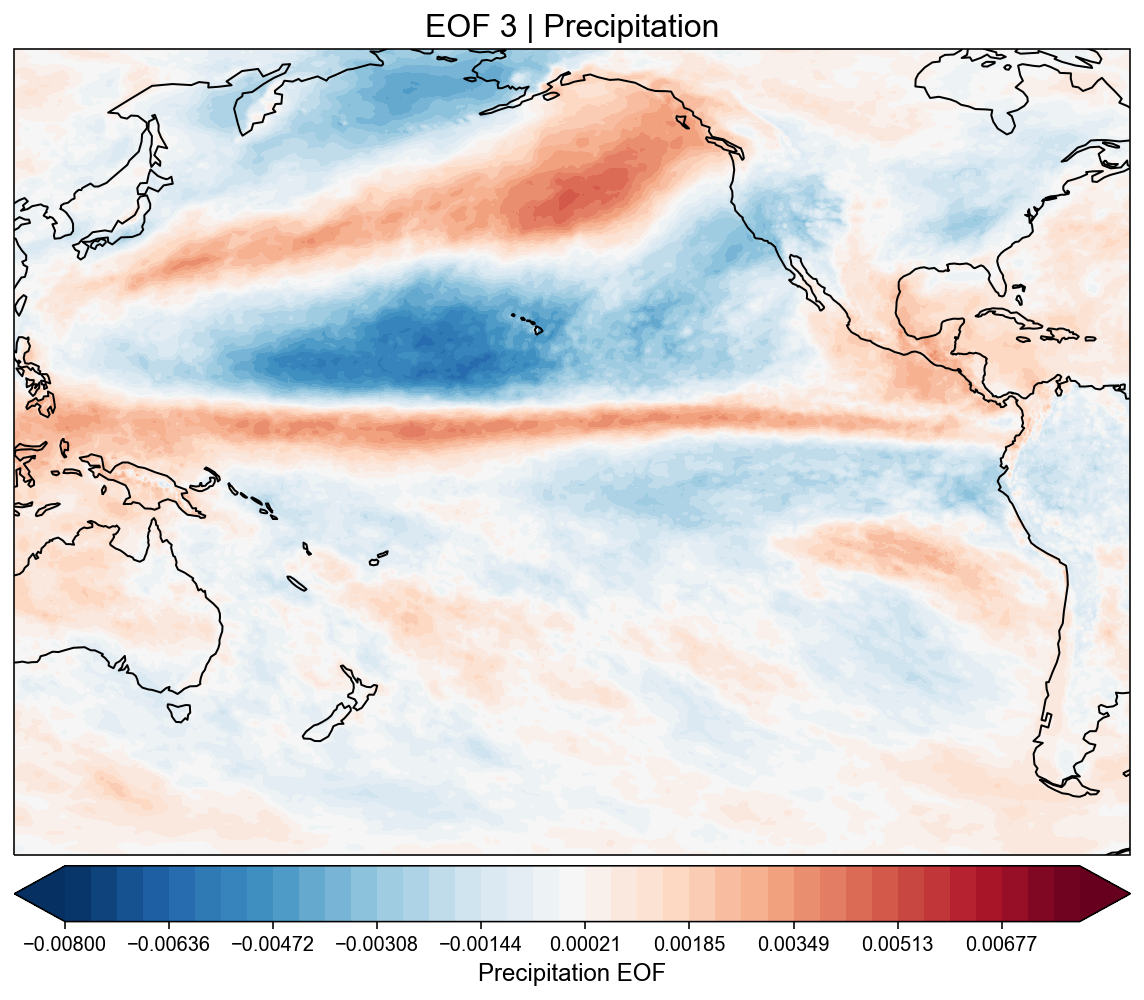

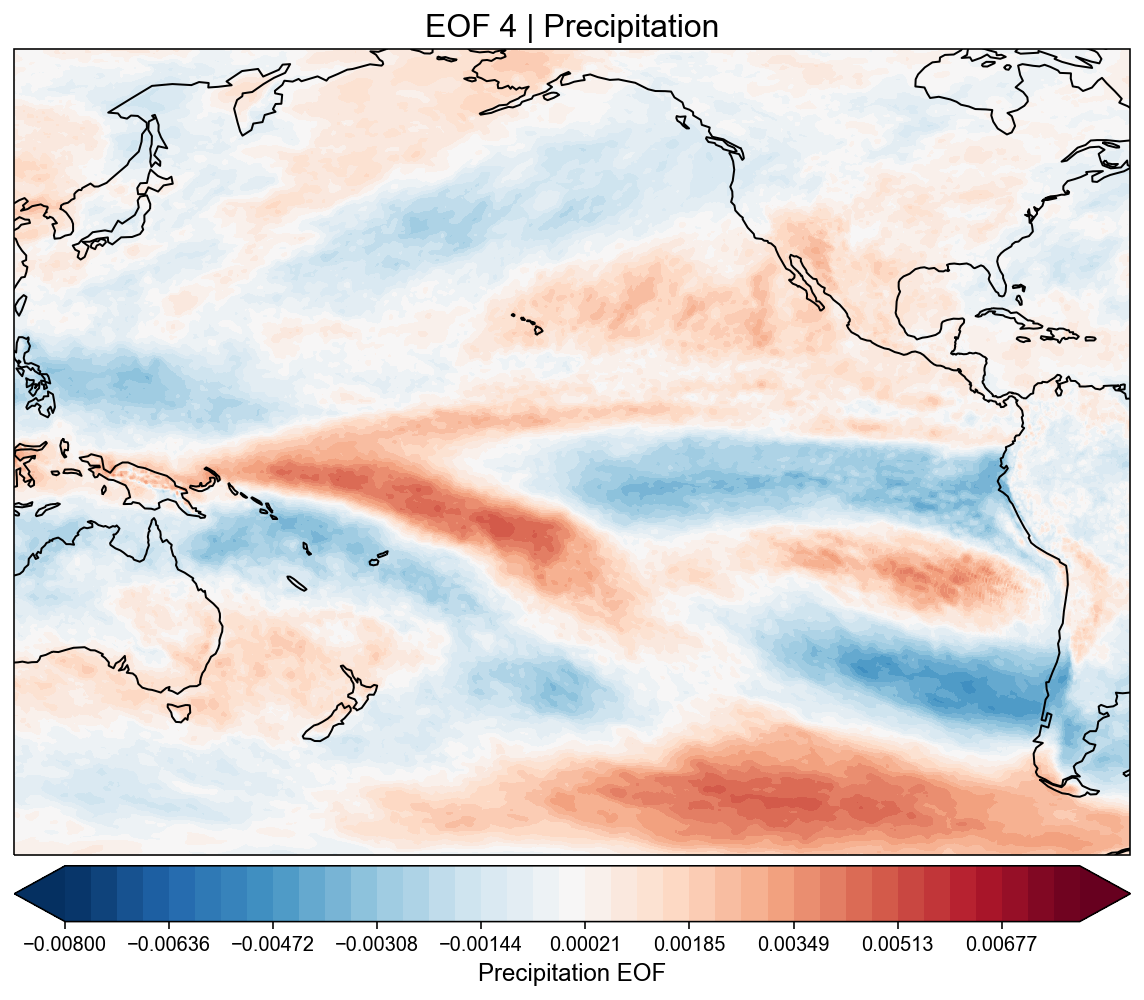

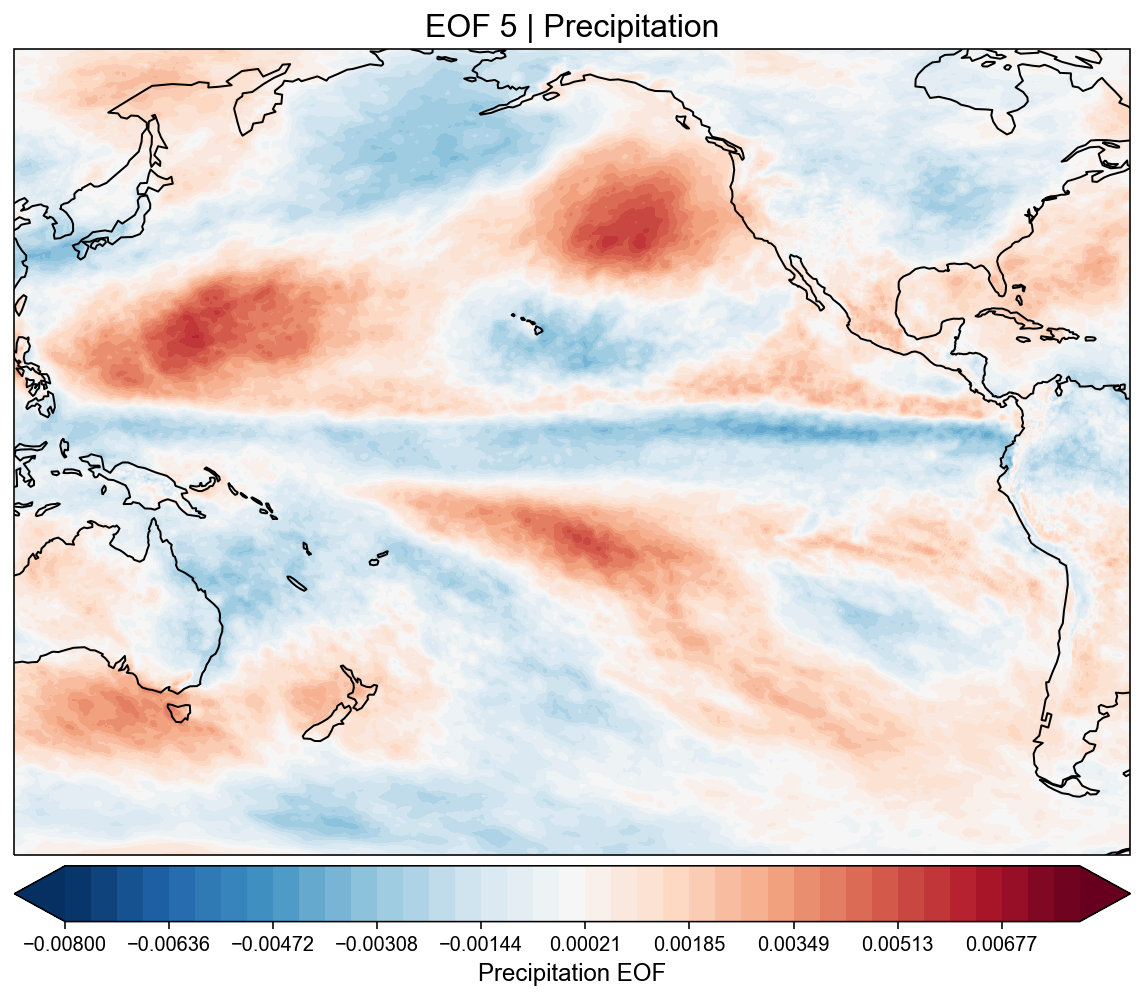

In [16]:
for i in range(len(pre_eofs)): 

    clevs = np.linspace(-0.008, 0.008, 40)

    fig = plt.figure(figsize = (10, 10))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))

    fill = ax.contourf(pre_eofs.longitude.values, pre_eofs.latitude.values, pre_eofs[i].data, levels = clevs, cmap=plt.cm.RdBu_r,
                                     add_colorbar=False, transform=ccrs.PlateCarree(), extend = 'both')

    ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
    cb = plt.colorbar(fill, orientation='horizontal', pad = 0.01)

    cb.set_label('Precipitation EOF', fontsize=12)
    ax.set_title('EOF ' + str(i + 1) + ' | Precipitation', fontsize=16)

    plt.show()

4. Plot the percent of variance explained by the first 10 EOFs.

In [17]:
#Variance explained by the first 10 EOFs
sst_variance_fractions = sst_solver.varianceFraction(neigs=10)
pre_variance_fractions = pre_solver.varianceFraction(neigs=10)

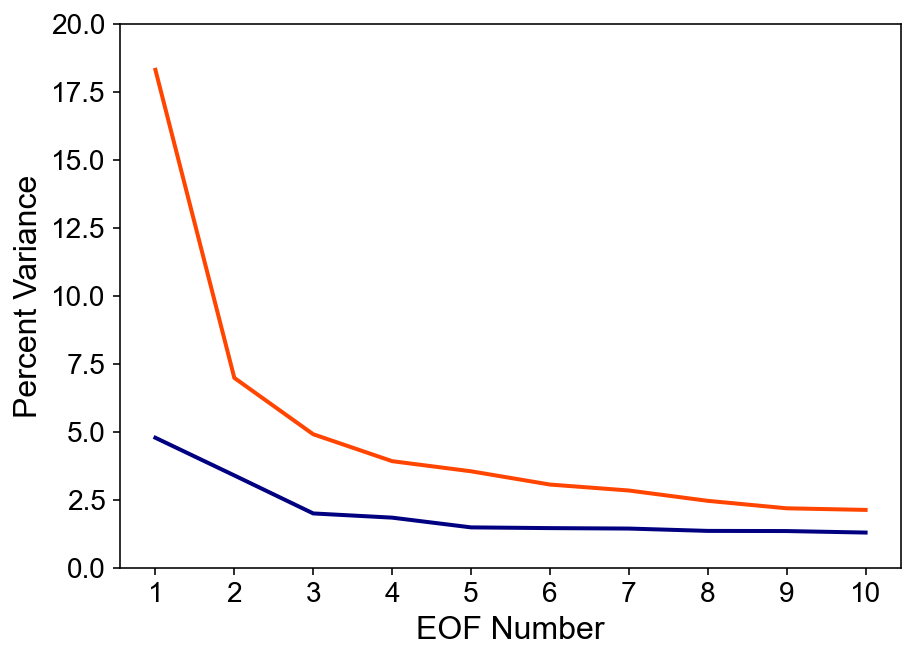

In [18]:
plt.figure(figsize = (7, 5))

plt.plot(sst_variance_fractions.mode + 1, sst_variance_fractions.data * 100, color = 'orangered', linewidth = 2, label = 'SST EOF Variance')
plt.plot(pre_variance_fractions.mode + 1, pre_variance_fractions.data * 100, color = 'navy', linewidth = 2, label = 'Precipitaiton EOF Variance')

plt.ylim(0, 20)

plt.ylabel('Percent Variance', fontsize = 16)
plt.xlabel('EOF Number', fontsize = 16)

plt.tick_params(labelsize = 14)

plt.xticks(np.arange(1, 11, 1))
plt.legend(fontsize = 14)
plt.show()

5. Reconstruct the SST field using the first 5 EOFs and plot a map of the Pearson's correlation coefficient (xarray.corr) of the reconstructed monthly time series and the "observed" SST time series.

In [19]:
#building a reconstructed EOF based on hte first five EOFs 
reconstructed_sst = sst_solver.reconstructedField(5)

In [20]:
#correlating monthly time series and observed SSTS
correlation_sst = xr.corr(reconstructed_sst, mms['SSTK'], dim = 'time')

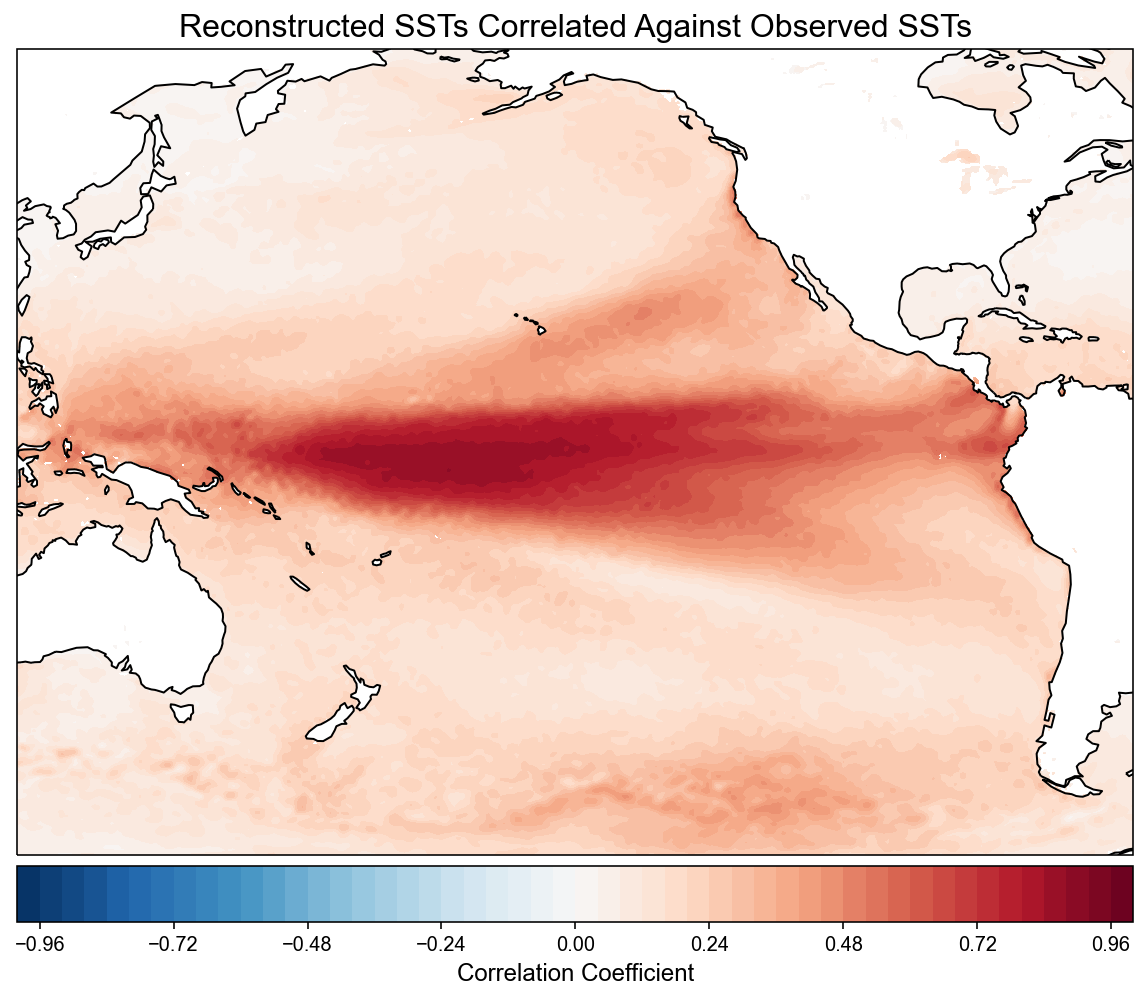

In [21]:
clevs = np.linspace(-1, 1, 51)

fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))

fill = ax.contourf(sst_eofs.longitude.values, sst_eofs.latitude.values, correlation_sst.data, levels = clevs, cmap=plt.cm.RdBu_r,
                   add_colorbar=False, transform=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal', pad = 0.01)

cb.set_label('Correlation Coefficient', fontsize=12)
ax.set_title('Reconstructed SSTs Correlated Against Observed SSTs', fontsize=16)

plt.show()

6. Compute a map of the Pearson's correlation coefficient between SST EOF1 and monthly mean detrended, deseasonalized, and standardized monthly mean precipitation anomalies (don't mask these over land for the plot). See anything interesting?

In [22]:
#SST EOF and monthly mean correlation 
sst_eof_1 = sst_solver.eofs(neofs=1)

In [23]:
correlation_detrend = xr.corr(reconstructed_sst, anomalies_mmp, dim = 'time')
correlation_deseasonalized = xr.corr(reconstructed_sst, mmp['TP'], dim = 'time')
correlation_standardized = xr.corr(reconstructed_sst, pre_stand, dim = 'time')

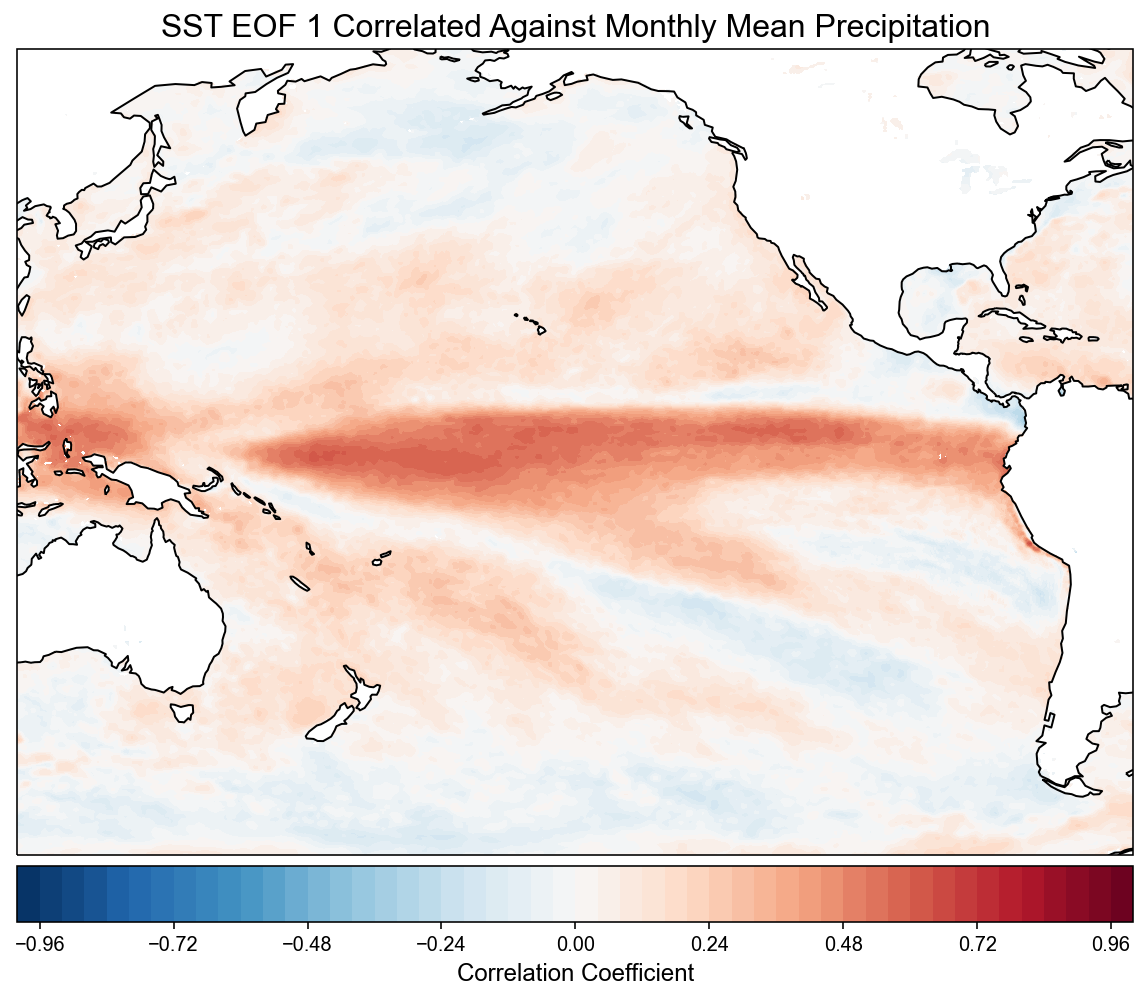

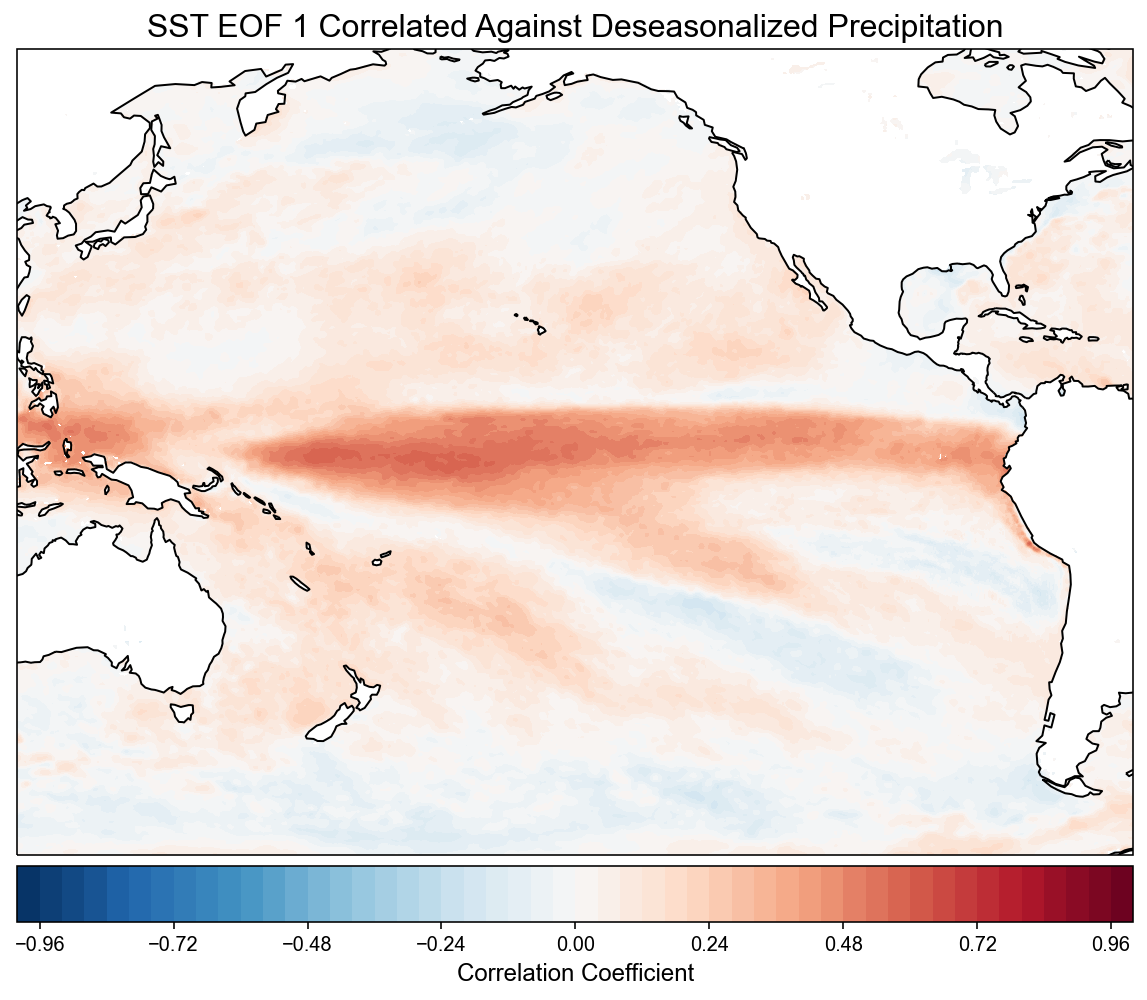

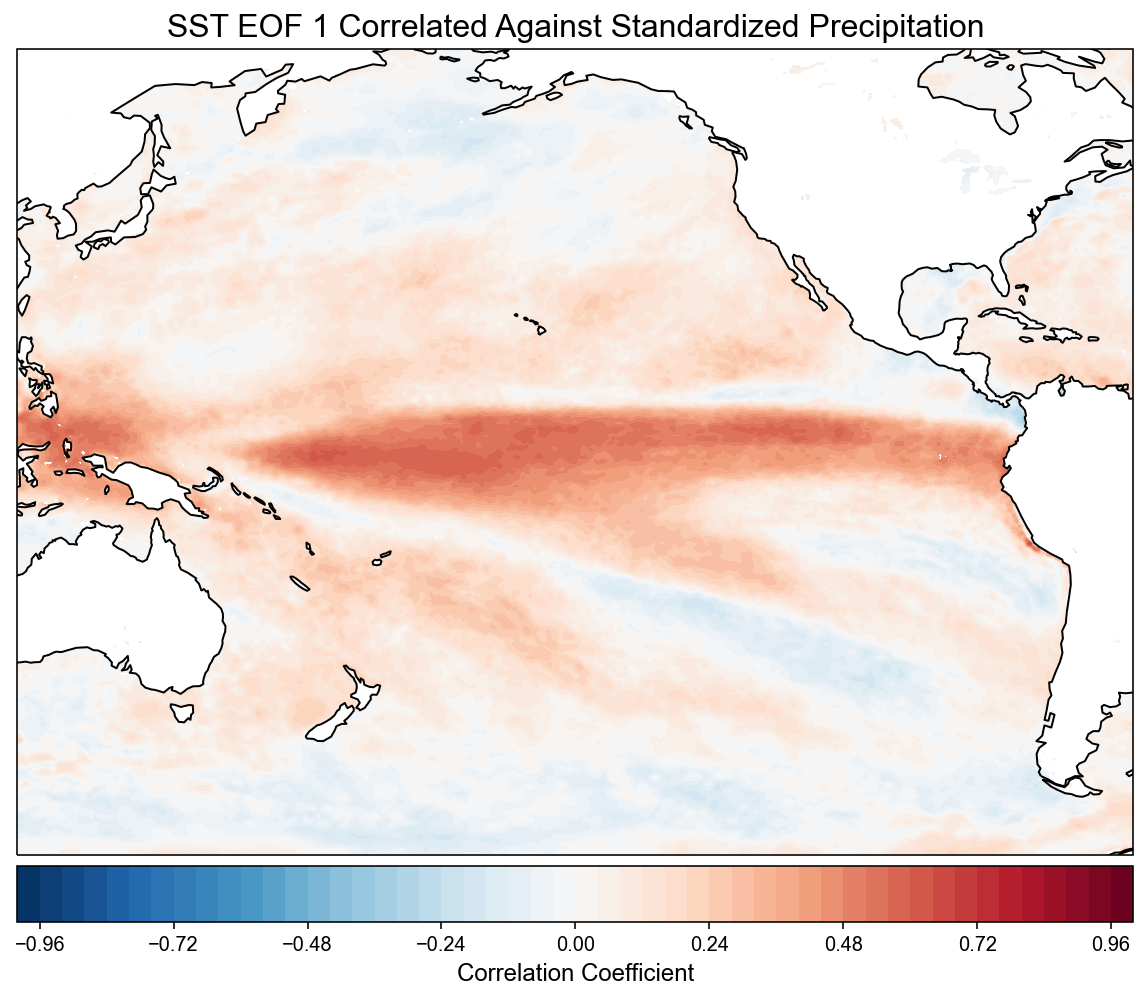

In [24]:
#Monthly Mean Detrended 
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))

fill = ax.contourf(sst_eofs.longitude.values, sst_eofs.latitude.values, correlation_detrend.data, levels = clevs, cmap=plt.cm.RdBu_r,
                   add_colorbar=False, transform=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal', pad = 0.01)

cb.set_label('Correlation Coefficient', fontsize=12)
ax.set_title('SST EOF 1 Correlated Against Monthly Mean Precipitation', fontsize=16)

plt.show()


#Deseasonalized
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))

fill = ax.contourf(sst_eofs.longitude.values, sst_eofs.latitude.values, correlation_deseasonalized.data, levels = clevs, cmap=plt.cm.RdBu_r,
                   add_colorbar=False, transform=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal', pad = 0.01)

cb.set_label('Correlation Coefficient', fontsize=12)
ax.set_title('SST EOF 1 Correlated Against Deseasonalized Precipitation', fontsize=16)

plt.show()


#Standardized Monthly Mean Precipitation 
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))

fill = ax.contourf(sst_eofs.longitude.values, sst_eofs.latitude.values, correlation_standardized.data, levels = clevs, cmap=plt.cm.RdBu_r,
                   add_colorbar=False, transform=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal', pad = 0.01)

cb.set_label('Correlation Coefficient', fontsize=12)
ax.set_title('SST EOF 1 Correlated Against Standardized Precipitation', fontsize=16)

plt.show()